# Prostate Imaging Test - Segmentation

## Imports

In [2]:
import nibabel as nb
import dicom2nifti
import shutil
import os
import matplotlib.pyplot as plt

## Data Exploration & Pre-processing

### Convert DICOM to NIFTI

In [ ]:
output_dir = 'Dataset001_Prostate/imagesTr'
dicom_dir = 'Dataset001_Prostate/imagesTr'

dicom2nifti.convert_directory(dicom_dir, output_dir)

### Rename and gzip files

In [3]:
def main():
    folder_path = 'Dataset002_Prostate/imagesTr'
    for count, filename in enumerate(sorted(os.listdir(folder_path))):
        dst = f"PCA_" + str(count).zfill(3) + ".nii"
        
        src = f"{folder_path}/{filename}"
        dst = f"{folder_path}/{dst}"
        
        os.rename(src, dst)

if __name__ == '__main__':
    main()

In [ ]:
import gzip

def gzip_dir(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        
        if os.path.isfile(file_path) and not filename.endswith('.gz'):
            gzipped_file_path=f"{file_path}.gz"
        
        with open(file_path, 'rb') as f_in:
            with gzip.open(gzipped_file_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

In [ ]:
directory = 'Dataset001_Prostate/imagesTr'
gzip_dir(directory)

### Explore training images

In [4]:
tr1 = nb.load('Dataset002_Prostate/lesions/images/ADC/ProstateX-0000_ep2d_diff_tra_7.nii.gz')
print(tr1)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (84, 128, 19)
affine:
[[-1.99999845e+00  4.00670191e-10 -3.77059286e-03  4.56854477e+01]
 [ 7.97220971e-04  1.89675295e+00 -9.51440334e-01 -1.28171722e+02]
 [-2.38395948e-03  6.34293675e-01  2.84512877e+00 -9.75016937e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 54
dim             : [  3  84 128  19   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.   2.   2.   3.   2.7  0.   0.   0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max    

In [5]:
tr1_fdata = tr1.get_fdata()
print(tr1_fdata.dtype, tr1_fdata.shape)

float64 (84, 128, 19)


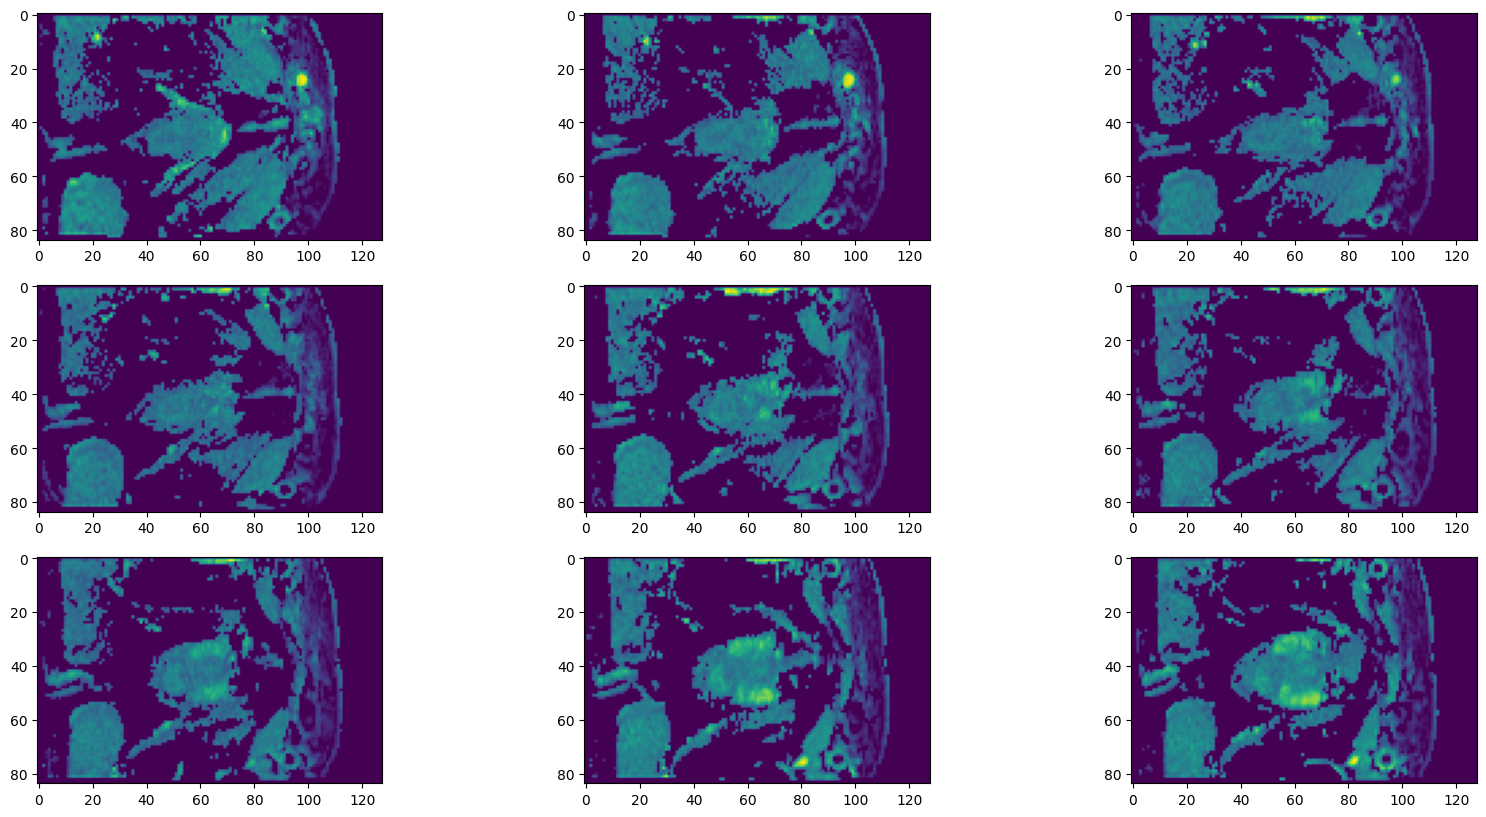

In [6]:
fig, axis = plt.subplots(3, 3, figsize=(20, 10))

slice_counter = 0
for i in range(3):
    for j in range(3):
        axis[i][j].imshow(tr1_fdata[:,:,slice_counter])
        slice_counter+=1

### Explore annotations

In [9]:
mask1 = nb.load('Dataset001_Prostate/labelsTr/PCA_000.nii.gz')
print(mask1)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (84, 128, 19)
affine:
[[-1.99999829e+00 -1.66481957e-05 -3.92400983e-03  4.56854477e+01]
 [ 8.13869501e-04  1.89675288e+00 -9.51439773e-01 -1.28171722e+02]
 [-2.48623890e-03  6.34293704e-01  2.84512688e+00 -9.75016937e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3  84 128  19   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.  2.  2.  3.  0.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.

In [10]:
mask1_fdata = mask1.get_fdata()
print(mask1_fdata.dtype, mask1_fdata.shape)

float64 (84, 128, 19)


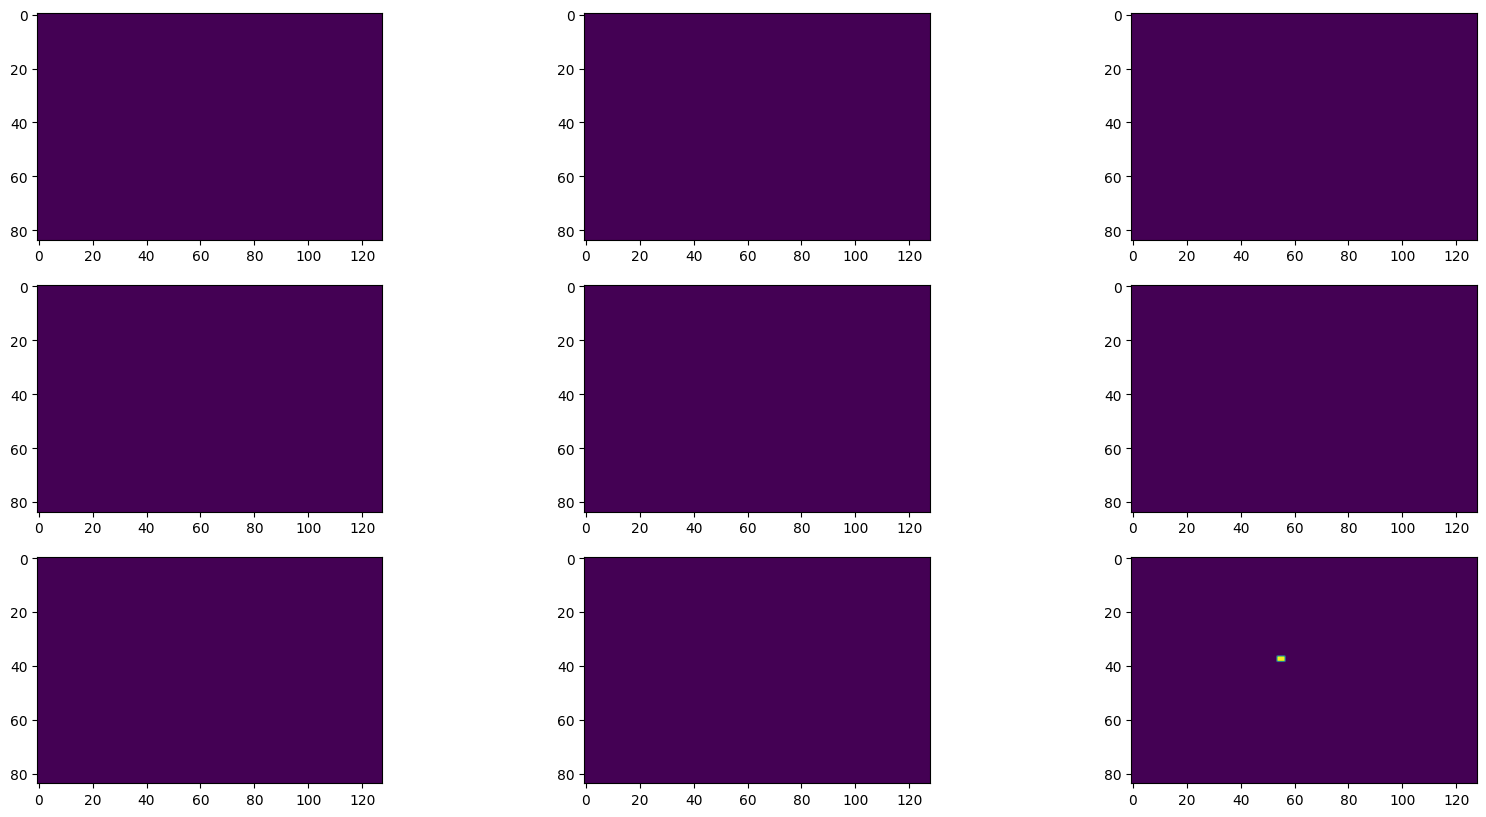

In [11]:
fig, axis = plt.subplots(3, 3, figsize=(20, 10))

slice_counter = 0
for i in range(3):
    for j in range(3):
        axis[i][j].imshow(mask1_fdata[:,:,slice_counter])
        slice_counter+=1